## EnvironNet- A Trash Image Classification Project

Building a **Custom Convolutional Neural Network (CNN)** to classify trash images into **10 categories**:
**shoes, battery, trash, clothes, plastic, paper, metal, glass, cardboard, biological.**

1. **Dataset Preparation**

   * Each class has **1000 images**.
   * The dataset is split into **Train, Validation, and Test** sets.
   * Data augmentation (rotation, flips, color jitter, etc.) is applied **only to the training set** to improve generalization.
   * Validation and Test sets use the **original images** only (no augmentation).

2. **Model Architecture**
   * Input: **224×224 RGB images**.
   * CNN layers with **Conv → ReLU → BatchNorm → MaxPool**.
   * Fully connected layers with **Dropout** for regularization.
   * Output: **10 softmax probabilities** (multi-class classification).

3. **Training Setup**

   * **Loss Function**: CrossEntropyLoss.
   * **Optimizer**: Adam with learning rate **0.001** and **L2 weight decay**.
   * **Scheduler**: ReduceLROnPlateau to lower learning rate when validation loss stops improving.
   * **Regularization**: Dropout (0.5) + Weight Decay (1e-4).
   * **EarlyStopping** is used to avoid overfitting.

---

## 📊 Evaluation Reports

1. **Accuracy** (Train, Validation, Test)
2. **Loss curves** (Training vs Validation loss across epochs)
3. **Accuracy curves** (Training vs Validation accuracy across epochs)
4. **Classification Report** (Precision, Recall, F1-score per class)
5. **Confusion Matrix** (which classes are being confused)
6. **Inference examples** (show a few test images with predicted labels + confidence)




In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -q /content/dataset_main.zip -d /content/data/

In [ ]:
!ls /content/data/


dataset_main


In [ ]:
!ls /content/data/dataset_main

battery    clothes  metal    paper    shoes
cardboard  glass    organic  plastic  trash


In [ ]:
# num images per class check
# List all class folders
import os
data_dir  = "/content/data/dataset_main"
classes = os.listdir(data_dir)

# Count images in each folder
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        num_images = len(os.listdir(cls_path))
        print(f"{cls}: {num_images} images")

battery: 1000 images
plastic: 1001 images
cardboard: 1000 images
clothes: 1000 images
shoes: 1000 images
glass: 1000 images
paper: 1000 images
metal: 1000 images
organic: 1001 images
trash: 1008 images


In [ ]:
bad_extensions = (".webp", ".avif")
hidden_files = (".DS_Store",)

# Walk through each class folder
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        for f in os.listdir(cls_path):
            f_path = os.path.join(cls_path, f)
            # Delete files with bad extensions or hidden files
            if f.lower().endswith(bad_extensions) or f in hidden_files:
                try:
                    os.remove(f_path)
                    print(f"Deleted: {f_path}")
                except Exception as e:
                    print(f"Failed to delete {f_path}: {e}")

Deleted: /content/data/dataset_main/battery/photo-1608224873587-81ee37394b4e.avif
Deleted: /content/data/dataset_main/battery/photo-1706275399494-fb26bbc5da63.avif
Deleted: /content/data/dataset_main/battery/howtorecyclebatteries-2048px-5661-3x2-1.webp
Deleted: /content/data/dataset_main/battery/photo-1613207012467-58f20a42a6a1.avif
Deleted: /content/data/dataset_main/battery/photo-1637773339519-679b29199c18.avif
Deleted: /content/data/dataset_main/battery/photo-1637773339519-679b29199c18-1.avif
Deleted: /content/data/dataset_main/battery/photo-1550496923-a0e3ef948e3a.avif
Deleted: /content/data/dataset_main/battery/photo-1550496923-a0e3ef948e3a-1.avif
Deleted: /content/data/dataset_main/plastic/iStock-1203040111.webp
Deleted: /content/data/dataset_main/plastic/E722A374-1AD5-4A71-9ABB7C93DE929DD6_source.webp
Deleted: /content/data/dataset_main/plastic/8256.webp
Deleted: /content/data/dataset_main/plastic/iStock_000008814554_Large.webp
Deleted: /content/data/dataset_main/plastic/.DS_Sto

In [ ]:
classes = os.listdir(data_dir)

# Count images in each folder
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        num_images = len(os.listdir(cls_path))
        print(f"{cls}: {num_images} images")

battery: 992 images
plastic: 996 images
cardboard: 1000 images
clothes: 991 images
shoes: 1000 images
glass: 1000 images
paper: 1000 images
metal: 989 images
organic: 1000 images
trash: 989 images


In [ ]:
# import the libraries
import copy, math, random, time
import numpy as np
from pathlib import Path

# pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt



In [ ]:
# Config

SEED = 42
DATA_DIR = "/content/data/dataset_main"
BATCH_SIZE = 32
EPOCHS =50
LR =1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 7  # for early stopping
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
IMG_SIZE = 224
NUM_CLASSES = 10
CKPT_PATH = "trash_cnn_best.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Reproducibility
def set_seed(seed=SEED):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.determininstic=True
  torch.backends.cudnn.benchmark= False


In [ ]:
set_seed()

In [ ]:
# Transform

# base one for val/ test/ single inference
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


# augmented transforms for training
aug_transform= transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15,saturation=0.15, hue=0.02),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85,1.0),ratio=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


In [ ]:
# Dataset
full_base = datasets.ImageFolder(DATA_DIR, transform=base_transform)
class_to_idx = full_base.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print(class_to_idx)
print(idx_to_class)
# a list of label in my dataset 0-9 for 10 classes
targets = np.array(full_base.targets)
print(len(targets))

{'battery': 0, 'cardboard': 1, 'clothes': 2, 'glass': 3, 'metal': 4, 'organic': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}
{0: 'battery', 1: 'cardboard', 2: 'clothes', 3: 'glass', 4: 'metal', 5: 'organic', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}
9957


In [ ]:
# Stratified train/val/test aplit

# creates an array of all dataset indices
# will use these indices to select which images go into train/val/test.
indices = np.arange(len(targets))

# split off test
train_idx , test_idx = train_test_split(
    indices,
    test_size = TEST_SPLIT,
    stratify=targets, # has the same class proportions as the orignal dataset
    random_state=SEED # split reproducible(same split every time)
)

# split train into train/val
train_idx, val_idx= train_test_split(
    train_idx, test_size= VAL_SPLIT/(1-TEST_SPLIT),
    stratify= targets[train_idx], # class proportions in validation same as in train.
    random_state=SEED
)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")



Train: 6969, Val: 1494, Test: 1494


In [ ]:
# Build datasets for train, test and val

# for Original Train data
train_orig = Subset(datasets.ImageFolder(DATA_DIR,transform = base_transform),train_idx)

# Augmentaed train data
train_aug = Subset(datasets.ImageFolder(DATA_DIR,transform=aug_transform), train_idx)

# Combine/Concat original+ augmented dataset
train_ds = ConcatDataset([train_orig,train_aug])

# Validation & Test Dataset (NO Augmentation!)
val_ds = Subset(datasets.ImageFolder(DATA_DIR, transform= base_transform),val_idx)
test_ds = Subset(datasets.ImageFolder(DATA_DIR, transform=base_transform),test_idx)


In [ ]:
 print(len(train_ds))

13938


In [ ]:
# DataLoader to feed into cnn
# train
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2, # number of CPU threads to load the data in parallel( 2 images at a time )
    pin_memory=True
)
# val
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
# test
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)



In [ ]:
print(f"Train (original+aug): {len(train_ds)}  | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train (original+aug): 13938  | Val: 1494 | Test: 1494


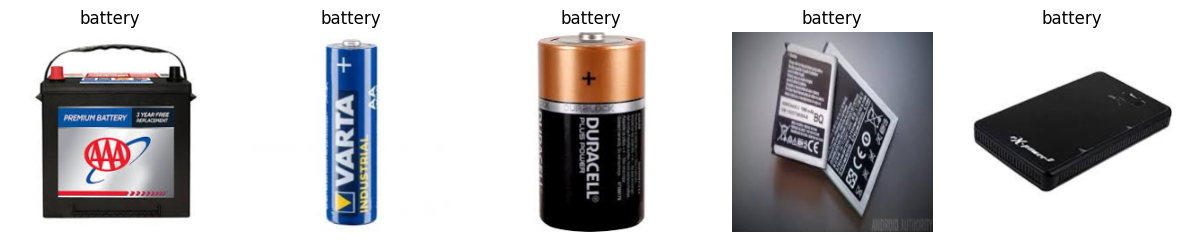

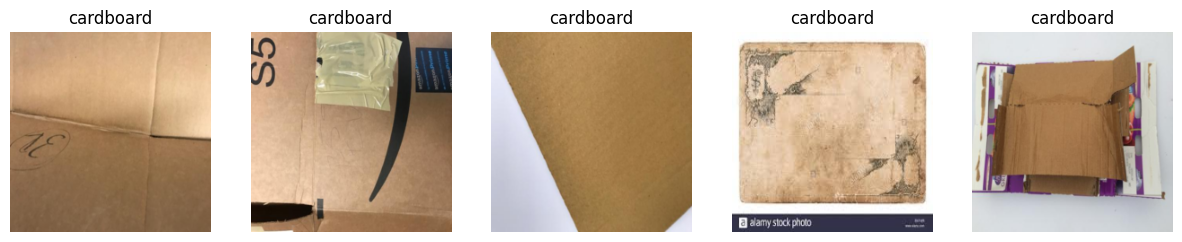

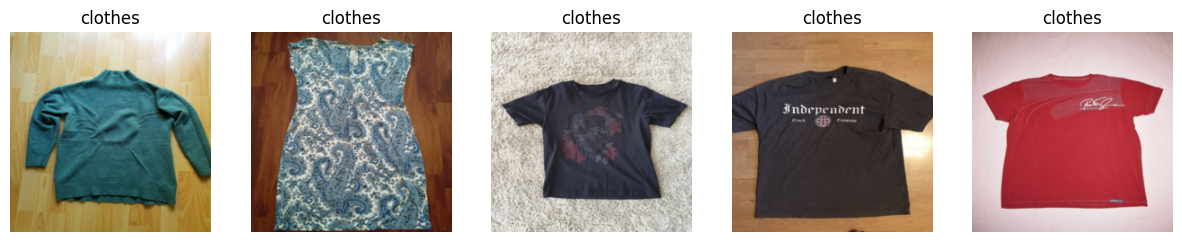

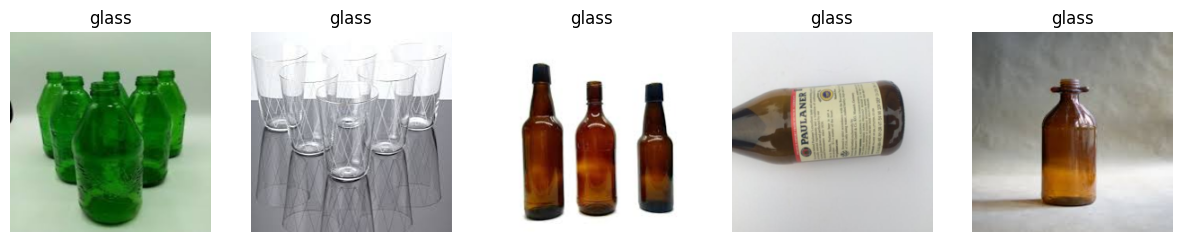

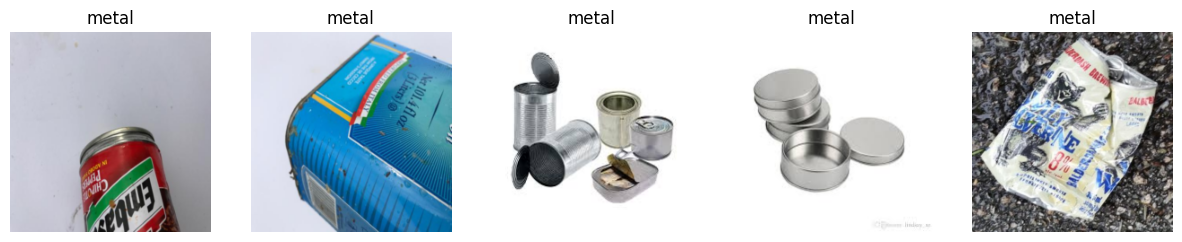

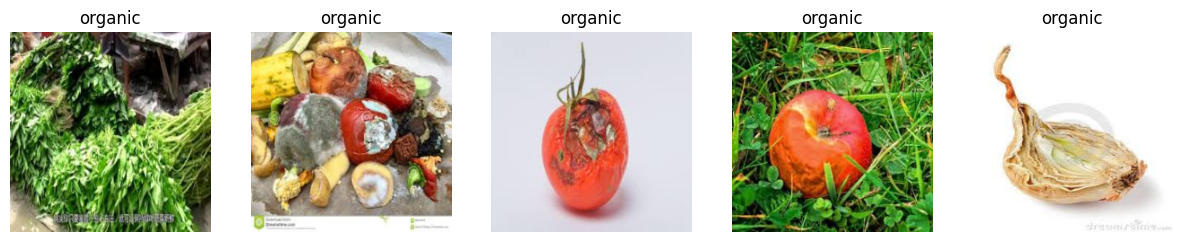

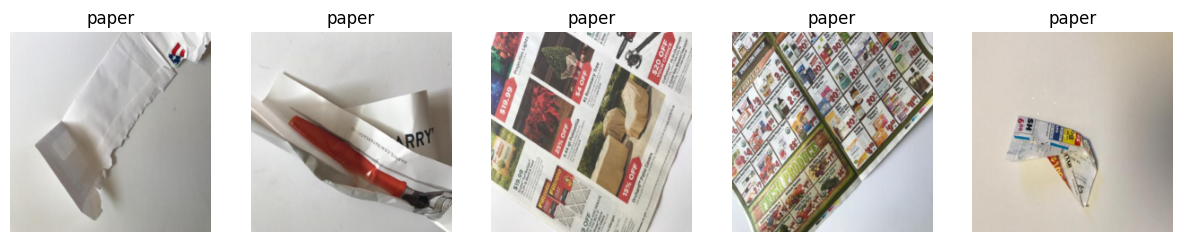

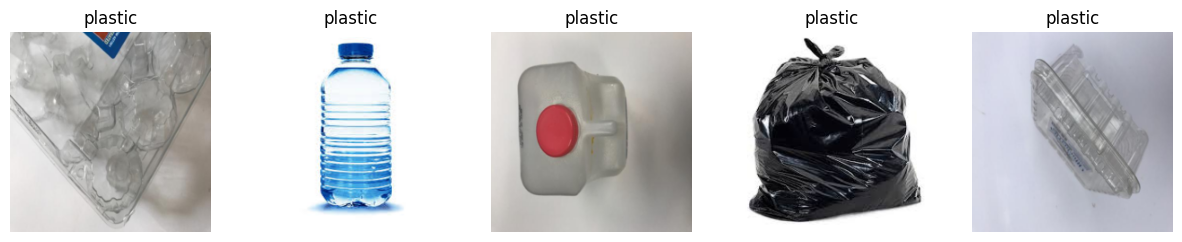

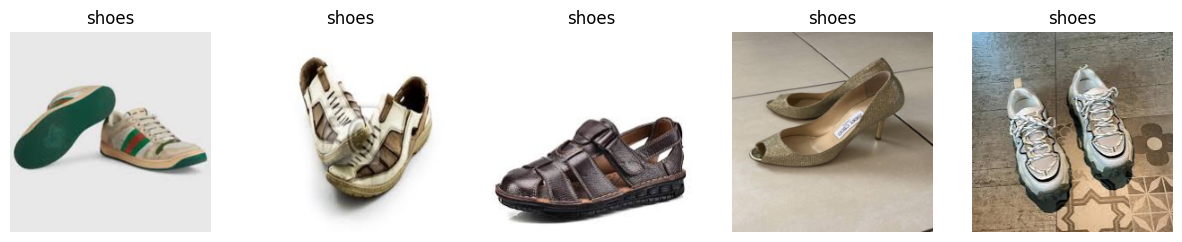

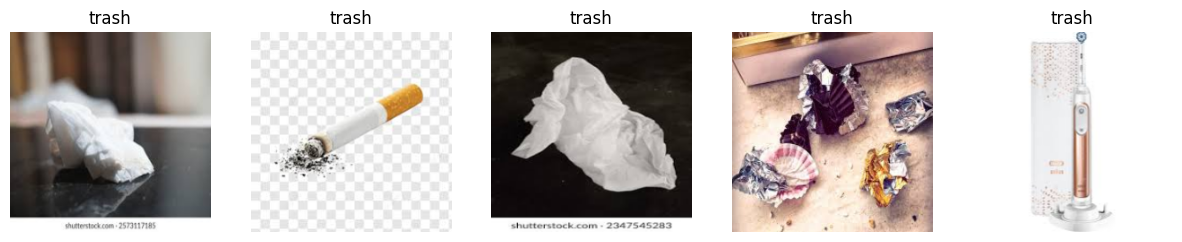

In [ ]:
# Access the original ImageFolder dataset
first_subset = train_loader.dataset.datasets[0]  # train_orig
orig_dataset = first_subset.dataset  # this is the ImageFolder

# Number of images to show per class
images_per_class = 5

for class_idx, class_name in enumerate(orig_dataset.classes):
    # Get all indices for this class
    class_indices = [i for i, label in enumerate(orig_dataset.targets) if label == class_idx]

    # Sample a few images from this class
    sample_indices = random.sample(class_indices, min(images_per_class, len(class_indices)))

    plt.figure(figsize=(15,3))
    for i, idx in enumerate(sample_indices):
        img, label = orig_dataset[idx]
        img = img.permute(1,2,0).numpy()  # CHW -> HWC
        img = img * [0.5,0.5,0.5] + [0.5,0.5,0.5]  # unnormalize
        img = img.clip(0,1)

        plt.subplot(1, images_per_class, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

In [ ]:
img,label = orig_dataset[0]
img.shape

torch.Size([3, 224, 224])

In [ ]:
# Model

class DeepCNN(nn.Module): # inherits from nn.Module
  def __init__(self, num_classes= NUM_CLASSES):
    super().__init__()

    # helper function for "block" of CNN layers (4 layers in here )
    def block(in_c, out_c):

      """
      in_c - input channels
      ou_c - ouput channels (features -> feature map output)
      kernel aka filters - 3x3
      padding =1 - keeps spatial size the same before pooling


      BatchNorm2d - Normalize the outputs from conv layer for faster, more stable training
      ReLU - ReLU activation function [ f(x) = max(0,x)] - adding non-linearity for n
      MaxPool2d - Downsamples that feature map by a factor of 2 ( halves height & weight )

      3x224x224 -> image shape
      so 3 -> 32 features -> got a feature map -> BatchNorm -> ReLU -> MaxPool -> 112
      then 32 -> 64 features -> got a feature map -> BatchNorm -> ReLU -> MaxPool -> 56
      and so on there fore

      Block 1 - input size 224 -> output size 112
      Block 2 - input size 112 -> ouput size 56
      Block 3 - input size 56 -> output size 28
      Block 4 - input size 28 -> output size 14

      channels depth increase 3 ( R, G, B ) -> 32-> 64-> 128-> 256  (learns more complex features at deeper layers)

      Flatten Layer -----
      After the last conv block -> the feature map is 256 x 14 x 14
      will apply torch.flatten(x,1) in feed forward function converting that into 1-D vector
      so it can go into fully connected layer!


      Fully Connected Layers ----
      they take extracted features and predict the class .( Classifier )
      # first FC layer
      flatten features(50k)( output from last conv block) -> 512 units -> ReLU -> Dropout
      # second FC layer
      512 -> 256 -> ReLU -> Dropout
      # last FC Layer (final class logits)
      256 -> map to num_classes (10)

      """
      return nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3,padding=1, bias=False),
          nn.BatchNorm2d(out_c),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )

    # features , function call to "block"
    self.features = nn.Sequential(
        block(3, 32), # 244 -> 112 (max pool the 32 features )
        block(32, 64), # 112 -> 56
        block(64, 128), # 56 -> 28
        block(128 , 256) # 28 -> 14
    )

    # so now 14x14x256 = 50176 features
    self.flatten_dim= 256 * (IMG_SIZE //16) *(IMG_SIZE // 16)

      # fully connected (classifier) part of cnn
    self.classifier = nn.Sequential(
        nn.Linear(self.flatten_dim, 512), # flatten input (50176) maps them down to 512 neurons
        nn.ReLU(inplace =True), # replace neg value with 0
        nn.Dropout(0.5), # to prevent overfitting
        # second fc layer 512 -> 256
        nn.Linear(512, 256),
        nn.ReLU(inplace =True),
        nn.Dropout(0.5),
        # output layer ( no activation function ! will apply softmax auto by CrossEntroyLoss  )
        nn.Linear(256, num_classes)
    )

  def forward(self , x):
    x = self.features(x) # convolution phase
    x = torch.flatten(x,1) # flatten into 1-D
    x = self.classifier(x) # fully connected phase/final classifier phase

    return x



In [ ]:
# create model
model = DeepCNN().to(DEVICE)

# loss function for multi-class classification ( there is also binaryCrossEntropyLoss )
# output logits of size [batch_size, num_classes]
# apply softmax to turn logits into probabilities
# calculates the negative log-likelihood of the correct class -> tell nn how wrong its predictions are
criterion = nn.CrossEntropyLoss()

# Optimizer - use Adam (popular optimizer that adjusts lr for each parameters individually)
# combine momentum and RMSProp ideas
# weight_decay add L2 regularization to help reduce overfitting by penalizing large weights
optimizer = torch.optim.Adam(model.parameters(), lr =LR, weight_decay= WEIGHT_DECAY)


# LR Schedular  (adjust learning rate during training )
# mode = 'min' -> expect the metric (val loss) to decrease
# patience =2 -> wait 2 epochs without improvement before reduing LR
# print a message when lr is redu
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5,patience =2
)


In [ ]:
# Training Utils
# Early Stopping

class EarlyStopping:
  """
  patience : no of epochs to wait without improvement before stopping
  mode : "min" if want the metric to decrease (like loss)
  min_delta : minimum improvement required to reset patience
  best : keep track of the best metric so far
  num_bad : counts the consecutive epochs with no improvement
  should_stop : flag to whether should stop the training or not

  how it works------
  step function ,
  first check if the best is here if not set the first metric -> return False (keep the training)
  then check if the current metric improved? compared to best ?
  for min mode (loss) -> improvement means metric decreased by at least min_delta.
  for max mode (acc) -> improvement means metric increased by at least min_delta.
  >>> if improvedtthen the lowest loss reset the num_bad 0 , then
  >>> else increment the num_bad (dc about the lowest loss case)
  >>> if the consecutive num_bad > = patience then "STOP"

  """
  def __init__(self, patience=PATIENCE, mode="min", min_delta=0.0):
    self.patience = patience
    self.mode = mode
    self.min_delta= min_delta
    self.best = None
    self.num_bad =0
    self.should_stop =False

  # step function
  def step(self, metric):
    if self.best is None:
      self.best = metric
      return False

    improve = (metric < self.best - self.min_delta ) if self.mode == "min" \
              else (metric > self.best+ self.min_delta)


    if improve:
      self.best = metric
      self.num_bad = 0

    else:
      self.num_bad += 1
      if self.num_bad >= self.patience:
        self.should_stop = True

    return self.should_stop

In [ ]:
# function implementation for each epoch
def run_epoch(loader, model, optimizer=None):

    """
    loader -> DataLoader
    model -> cnn model
    optimizer -> if optimizer is provided (training mode ) else evaluation mode

    """
    is_train = optimizer is not None
    model.train(is_train)

    # keep tack of total loss, no of correct predictions , total images
    total_loss, total_correct, total_count = 0.0, 0, 0

    # lists to store all predictions and target labels
    all_preds, all_targets = [], []

    # loop thru batches
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        # model predictions (logits)
        outputs = model(imgs)
        # compute diff between predictions and true label along with using softmax
        loss = criterion(outputs, labels)

        if is_train:
            # back propagation ( don't need to define manually )
            loss.backward()
            # update model weights
            optimizer.step()

        total_loss += loss.item() * imgs.size(0) # sum of loss for all images in batch
        preds = outputs.argmax(dim=1) # predicted class

        total_correct += (preds == labels).sum().item()
        total_count += imgs.size(0)
        # .detach() → remove from computation graph
        # .cpu() → move tensor from GPU → CPU
        # .numpy() → convert to NumPy array for metrics like sklearn accuracy/confusion matrix
        all_preds.extend(preds.detach().cpu().numpy())
        all_targets.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / total_count
    acc = total_correct / total_count
    return avg_loss, acc, np.array(all_preds), np.array(all_targets)


In [ ]:
# Train the model

# to track val loss
best_val_loss = float("inf")

# instance for early stoppin function
early = EarlyStopping(patience=PATIENCE, mode="min")

# will store the weights of the best model
best_state = None

for epoch in range(1, EPOCHS+1):
    # track how long one epoch takes
    t0 = time.time()
    # in train mode optimizer provided
    train_loss, train_acc, _, _ = run_epoch(train_loader, model, optimizer)
    # in eval mode no optimizer and just on validation/test data
    val_loss, val_acc, _, _ = run_epoch(val_loader, model, optimizer=None)

    # adjust lr if val loss has
    scheduler.step(val_loss)

    # saving the best model
    # if the current validation loss is lower then before any seen
    if val_loss < best_val_loss:
        # update the best loss
        best_val_loss = val_loss
        # deep copy of that model's weights
        best_state = copy.deepcopy(model.state_dict())
        # save to the disk with some info
        torch.save({"model_state": best_state,
                    "class_to_idx": class_to_idx,
                    "config": {
                        "img_size": IMG_SIZE,
                        "num_classes": NUM_CLASSES
                    }}, CKPT_PATH)

    # pass current val loss to EarlyStopping analysis
    # if the loss hasn't improved for 7 consecutive epochs straight then -> return stop=True
    stop = early.step(val_loss)

    dt = time.time() - t0

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {dt:.1f}s")

    if stop:
        print(f"Early stopping at epoch {epoch}")
        break

[01/50] train_loss=2.2894 acc=0.2551 | val_loss=1.8276 acc=0.3461 | lr=1.00e-03 | 98.1s
[02/50] train_loss=1.9029 acc=0.3374 | val_loss=1.6856 acc=0.4458 | lr=1.00e-03 | 96.7s
[03/50] train_loss=1.8027 acc=0.3731 | val_loss=1.6592 acc=0.4177 | lr=1.00e-03 | 96.8s
[04/50] train_loss=1.7232 acc=0.4051 | val_loss=1.5607 acc=0.5100 | lr=1.00e-03 | 97.0s
[05/50] train_loss=1.6655 acc=0.4337 | val_loss=1.4899 acc=0.5241 | lr=1.00e-03 | 97.1s
[06/50] train_loss=1.5978 acc=0.4598 | val_loss=1.3932 acc=0.5341 | lr=1.00e-03 | 97.6s
[07/50] train_loss=1.5412 acc=0.4843 | val_loss=1.3919 acc=0.5361 | lr=1.00e-03 | 96.7s
[08/50] train_loss=1.4977 acc=0.5021 | val_loss=1.3509 acc=0.5509 | lr=1.00e-03 | 96.0s
[09/50] train_loss=1.4463 acc=0.5179 | val_loss=1.2980 acc=0.5636 | lr=1.00e-03 | 96.2s
[10/50] train_loss=1.3817 acc=0.5399 | val_loss=1.2487 acc=0.5803 | lr=1.00e-03 | 95.5s
[11/50] train_loss=1.3410 acc=0.5504 | val_loss=1.2063 acc=0.5997 | lr=1.00e-03 | 97.4s
[12/50] train_loss=1.2981 acc=0.

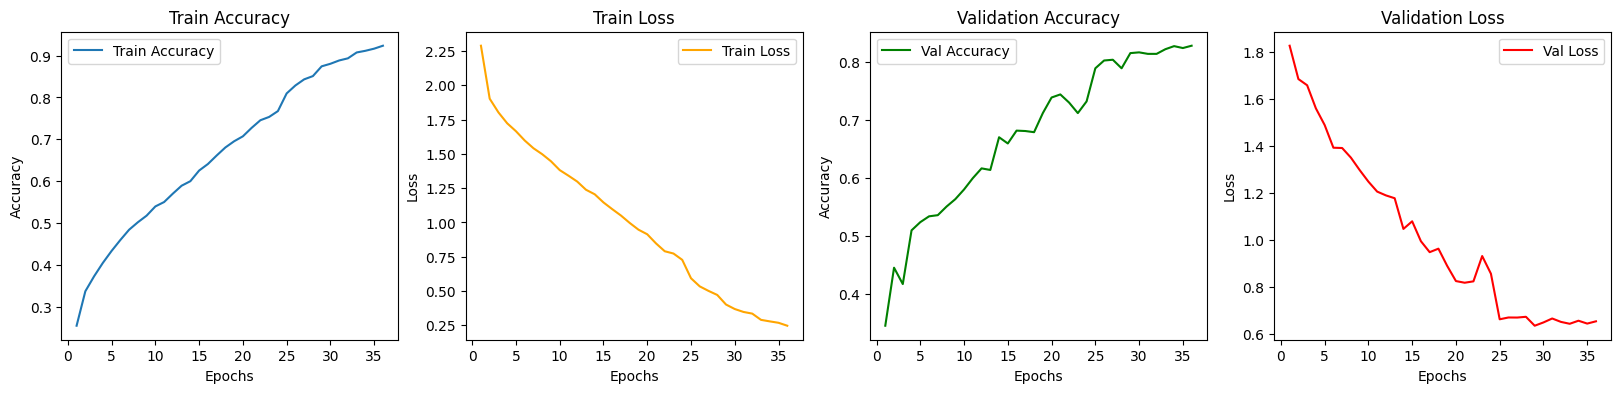

In [ ]:
# Visualization of training process

train_loss = [
    2.2894,1.9029,1.8027,1.7232,1.6655,1.5978,1.5412,1.4977,1.4463,1.3817,
    1.3410,1.2981,1.2384,1.2052,1.1458,1.0968,1.0500,0.9960,0.9469,0.9134,
    0.8469,0.7895,0.7728,0.7267,0.5924,0.5331,0.5002,0.4706,0.4007,0.3679,
    0.3465,0.3344,0.2888,0.2777,0.2674,0.2460
]
val_loss = [
    1.8276,1.6856,1.6592,1.5607,1.4899,1.3932,1.3919,1.3509,1.2980,1.2487,
    1.2063,1.1901,1.1780,1.0473,1.0797,0.9949,0.9483,0.9632,0.8899,0.8252,
    0.8181,0.8240,0.9318,0.8564,0.6624,0.6701,0.6698,0.6730,0.6350,0.6490,
    0.6658,0.6513,0.6433,0.6563,0.6441,0.6538
]
train_acc = [
    0.2551,0.3374,0.3731,0.4051,0.4337,0.4598,0.4843,0.5021,0.5179,0.5399,
    0.5504,0.5705,0.5894,0.6002,0.6256,0.6411,0.6614,0.6807,0.6955,0.7073,
    0.7275,0.7457,0.7536,0.7675,0.8097,0.8287,0.8433,0.8511,0.8744,0.8805,
    0.8884,0.8935,0.9075,0.9115,0.9166,0.9236
]
val_acc = [
    0.3461,0.4458,0.4177,0.5100,0.5241,0.5341,0.5361,0.5509,0.5636,0.5803,
    0.5997,0.6165,0.6138,0.6700,0.6593,0.6814,0.6807,0.6787,0.7115,0.7383,
    0.7436,0.7296,0.7115,0.7316,0.7885,0.8019,0.8032,0.7885,0.8146,0.8159,
    0.8133,0.8133,0.8213,0.8266,0.8233,0.8273
]

epochs = range(1, len(train_loss)+1)


plt.figure(figsize=(20,4))

# Train Accuracy
plt.subplot(1, 4, 1)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy")
plt.legend()


# Train Loss
plt.subplot(1, 4, 2)
plt.plot(epochs, train_loss, label="Train Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()

# Val Accuracy
plt.subplot(1, 4, 3)
plt.plot(epochs, val_acc, label="Val Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

# Val Loss
plt.subplot(1, 4, 4)
plt.plot(epochs, val_loss, label="Val Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

### Why it stopped at epoch 36?

| Epoch | val\_loss | Best so far | Improved? | num\_bad             |
| ----- | --------- | ----------- | --------- | -------------------- |
| 29    | 0.6350✅  | 0.6350      | ✅ Yes    | 0
| 30    | 0.6490    | 0.6350      | ❌ No      | 1                    |
| 31    | 0.6658    | 0.6350      | ❌ No      | 2                    |
| 32    | 0.6513    | 0.6350      | ❌ No      | 3                    |
| 33    | 0.6433    | 0.6350      | ❌ No      | 4                    |
| 34    | 0.6563    | 0.6350      | ❌ No      | 5                    |
| 35    | 0.6441    | 0.6350      | ❌ No      | 6                    |
| 36    | 0.6538    | 0.6350      | ❌ No      | 7  → patience hit  |


So basically:

* **Best model = epoch 29** (`val_loss = 0.6350, val_acc = 0.8146`)
* After that, val\_loss didn’t improve enough, early stopping triggered at epoch 36.

In [ ]:
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()


DeepCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# 📊 Model Evaluation Report

Test Accuracy: 0.8234
Test Loss: 0.6578

Metrics:
- Macro F1-score: 0.812
- Cohen's Kappa: 0.796
- MCC: 0.782
- Confusion Matrix Heatmap
- Classification Report Heatmap
- ROC Curves (per class)


## Loss and Accuracy of Test Data



In [ ]:

test_loss, test_acc, test_preds, test_targets= run_epoch(test_loader, model, optimizer=None)[:4]
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



Test Loss: 0.6558 | Test Acc: 0.8079


## Classification Report

In [ ]:
import pandas as pd

# Generate classification report as dict
report = classification_report(
    test_targets,
    test_preds,
    target_names=[idx_to_class[i] for i in range(NUM_CLASSES)],
    output_dict=True
)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Round for readability
df_report = df_report.round(2)

print("\n📊 Classification Report:\n")
df_report



📊 Classification Report:



precision  recall  f1-score  support
battery            0.82    0.74      0.78   149.00
cardboard          0.91    0.91      0.91   150.00
clothes            0.82    0.81      0.81   149.00
glass              0.77    0.76      0.76   150.00
metal              0.77    0.81      0.79   148.00
organic            0.87    0.88      0.87   150.00
paper              0.84    0.89      0.86   150.00
plastic            0.80    0.78      0.79   150.00
shoes              0.75    0.75      0.75   150.00
trash              0.73    0.74      0.74   148.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.81    0.81      0.81  1494.00
weighted avg       0.81    0.81      0.81  1494.00

## Confusion Matrix (HeapMap)

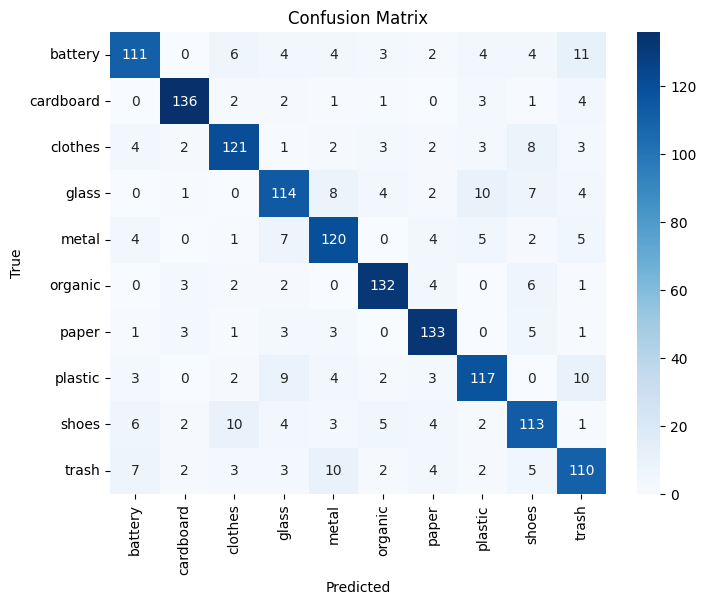

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)],
            yticklabels=[idx_to_class[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Single Image Inference

FileUpload(value={}, accept='image/*', description='Upload')

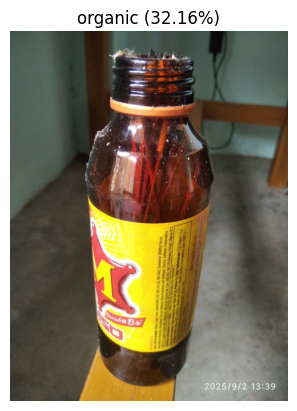

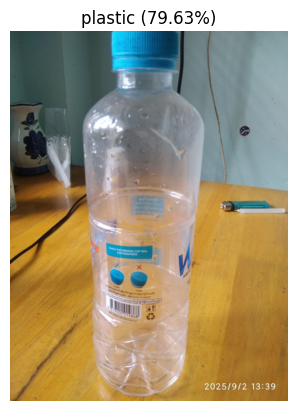

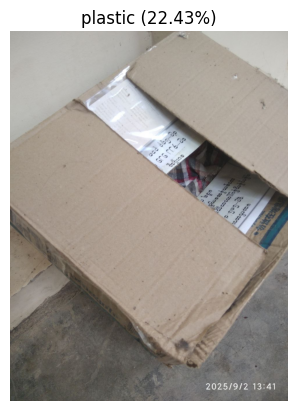

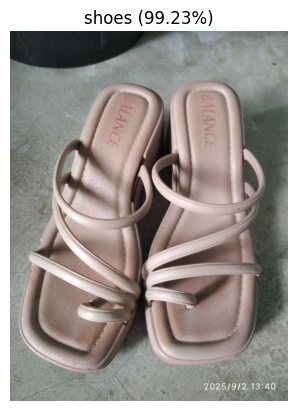

In [ ]:
# Single-image inference
import ipywidgets as widgets
from IPython.display import display
from PIL import Image


class_names = [
    "battery", "cardboard", "clothes", "glass", "metal",
    "organic", "paper", "plastic", "shoes", "trash"
]

inference_transform = base_transform  # no augmentation

def predict_image(img_path, model, class_names):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = inference_transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))
        return class_names[pred_idx], float(probs[pred_idx]), probs



uploader = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if uploader.value:
        # Get uploaded file
        uploaded_file = list(uploader.value.values())[0]
        content = uploaded_file['content']
        file_name = uploaded_file['metadata']['name']

        # Save temporarily
        with open(file_name, "wb") as f:
            f.write(content)

        # Predict
        pred_class, conf, probs = predict_image(file_name, model, class_names)

        # Show image with prediction + confidence
        img = Image.open(file_name).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{pred_class} ({conf*100:.2f}%)")
        plt.show()

uploader.observe(on_upload_change, names='value')
display(uploader)